# Анализ гипотез для увеличения выручки крупного интернет-магазина

## Описание проекта

Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки. Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты. Для реализации этой задачи имеются датасеты, содержащие информацию о 9 гипотезах по увеличению выручки интернет-магазина с указанными параметрами и результатами A/B-тестов. 

## Изучение и предобработка полученных днных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')

In [2]:
 pd.options.display.max_colwidth = 130

In [3]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

In [4]:
hypothesis.info()
print('Пропусков в таблице hypothesis:', hypothesis.isna().sum())
print ('Дубликатов в таблице hypothesis:', hypothesis.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
Пропусков в таблице hypothesis: Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64
Дубликатов в таблице hypothesis: 0


In [5]:
orders.info()
print('Пропусков в таблице orders:', orders.isna().sum())
print ('Дубликатов в таблице orders:', orders.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
Пропусков в таблице orders: transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64
Дубликатов в таблице orders: 0


In [6]:
visitors.info()
print('Пропусков в таблице visitors:', visitors.isna().sum())
print ('Дубликатов в таблице visitors:', visitors.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
Пропусков в таблице visitors: date        0
group       0
visitors    0
dtype: int64
Дубликатов в таблице visitors: 0


In [7]:
hypothesis.columns = hypothesis.columns.str.lower()
hypothesis.head(8)

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5


In [8]:
orders = orders.rename(columns={'transactionId':'transaction_id', 'visitorId':'visitor_id'})
orders['date'] = pd.to_datetime(orders['date'])
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transaction_id    1197 non-null int64
visitor_id        1197 non-null int64
date              1197 non-null datetime64[ns]
revenue           1197 non-null int64
group             1197 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [9]:
visitors['date'] = pd.to_datetime(visitors['date'])
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null datetime64[ns]
group       62 non-null object
visitors    62 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


### Вывод

По результатам предобработки имеющихся данных можно сделать следующие выводы:
во-первых, в датасетах отсутствуют пропущенные значения и дубликаты;
во-вторых, некоторые названия столбцов не были удобны для дальнейшей работы и были изменены на более хорошие врианты;
в-третьих, некоторые данные имели неправильный тип данных: колонки 'date' в таблицах orders и visitors имели текстовый тип и были преобразованы к типу даты.

Можно переходить к дальнейшим расчетам.

## Приоритизация гипотез

Для того, чтобы максимизировать ожидаемое улучшение ключевых метрик бизнеса, приоритизируем сформулированные гипотезы. Для этого используем один из самых популярных способов приоритизации задач - ICE, формула расчета которого представлена ниже.

$$ \ ICE = \frac{Impact * Confidence}{Efforts} $$

In [10]:
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
hypothesis[['hypothesis', 'ICE']].sort_values(by = 'ICE', ascending = False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


Применим фреймворк RICE (модификацию метода ICE) для приоритизации гипотез. Формула нахождения этого значения представлена ниже.

$$ \ RICE = \frac{Reach * Impact * Confidence}{Efforts} $$

In [11]:
hypothesis['RICE'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
hypothesis[['hypothesis', 'RICE']].sort_values(by = 'RICE', ascending = False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


### Вывод

На втором этапе исследования была проведена приоритизация гипотез с помощью фреймворков ICE и RICE. По результатам применения ICE наиболее перспективными гипотезами оказались 8, 0, 7 и 6, в свою очередь наиболее перспективные гипотезы по RICE - 7, 2, 0 и 6. Седьмая гипотеза вышла на первое место во втором случае во многом из-за максимальновысокого значения параметра Reach(какое кол-во пользователей затронут изменения), вторая гипотеза в лидерах также из-за высокого значения Reach. Восьмая гипотеза в лидеры не попала, так как ее Reach минимален, сответственно, это изменение практически не затронет пользователей, что не является хорошим показателем.

## Анализ A/B-теста

Перейдем к анализу имеющихся результатов A/B-теста. В первую очередь проверим данные на наличие ошибок и "перекосов".

In [12]:
print('Кол-во посетителей в группе А: {}\n'
      'Кол-во посетителей в группе B: {}'.format(visitors[visitors['group']=='A']['visitors'].sum(), 
                                                 visitors[visitors['group']=='B']['visitors'].sum()))

Кол-во посетителей в группе А: 18736
Кол-во посетителей в группе B: 18916


Как мы видим, разница между кол-вом посетителей незначительна, перекосов в сторону одну из групп не наблюдается.

In [13]:
abnormal_visitors = orders.groupby('visitor_id').agg({'group':'nunique'}).sort_values(by = 'group', ascending = False)
print(len(abnormal_visitors.query('group == 2'))/(len(abnormal_visitors)) *100)

5.625606207565471


Исследование данных показало, что у нас есть пользователи, которые попали как в группу А, так и в группу В. Кроме того, таких пользователей около 5%, что не является хорошим показателем. Возможно, следует уведомить об этом разработчиков. 

Следующим шагом построим график кумулятивной выручки по группам. Сделаем выводы и предположения.

In [14]:
datesGroups = orders[['date','group']].drop_duplicates()
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transaction_id' : pd.Series.nunique, 'visitor_id' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])
ordersAggregated.head(5)

,date,group,transaction_id,visitor_id,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874


In [15]:
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])
visitorsAggregated.head(5)

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


In [16]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
print(cumulativeData.head(5))

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      24      20   148579       719
1 2019-08-01     B      21      20   101217       713
2 2019-08-02     A      44      38   242401      1338
3 2019-08-02     B      45      43   266748      1294
4 2019-08-03     A      68      62   354874      1845


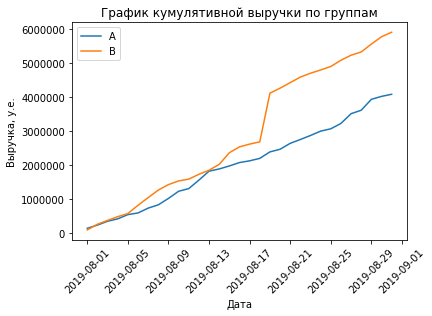

In [17]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title('График кумулятивной выручки по группам')
plt.xticks(rotation=45)
plt.ylabel("Выручка, у.е.")
plt.xlabel("Дата")
plt.legend()

Как можно увидеть из графика, в середине теста сегмент В обогнал А и продолжал лидировать до конца теста. Причиной этого могут выступать выбросы или очень крупные заказы, влияющие на результаты.

In [18]:
results = st.shapiro(orders.query('group == "A"')['revenue'])
p_value = results[
    1
] 
alpha = 0.05
print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально') 

p-значение:  1.739703399801917e-34
Отвергаем нулевую гипотезу: распределение не нормально


In [19]:
results = st.shapiro(orders.query('group == "B"')['revenue'])
p_value = results[
    1
] 
alpha = 0.05
print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально') 

p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


Как мы видим, распределение значений выручки не является нормальным, в связи с чем можно предположить наличие выбросов.

Построим график кумулятивного среднего чека по группам. Сделаем выводы.

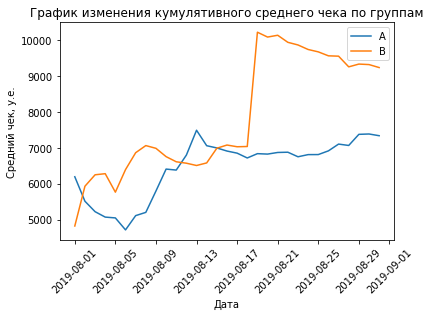

In [20]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('График изменения кумулятивного среднего чека по группам')
plt.ylabel("Средний чек, у.е.")
plt.xlabel("Дата")
plt.xticks(rotation=45)
plt.legend() 

График демонстрирует, что кумулятивное значение среднего чека по группам подвержено колебаниям(особенно заметным на графике группы В), в связи с чем принимать окончательные решения по метрике ещё рано.

Построим график относительного изменения кумулятивного среднего чека группы B к группе A. Сделаем выводы и предположения.

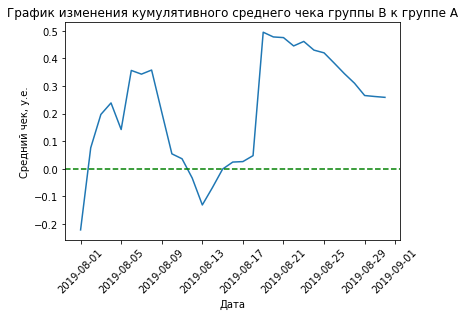

In [21]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.title('График изменения кумулятивного среднего чека группы B к группе A')
plt.ylabel("Средний чек, у.е.")
plt.xlabel("Дата")
plt.xticks(rotation=45)
plt.axhline(y=0, color='green', linestyle='--')

График демнстрирует, что результаты теста значительно менялись в некоторые периоды(спад 13 августа и резкий рост в 20-х числах августа). 

Построим график кумулятивной конверсии по группам. Сделайте выводы и предположения.

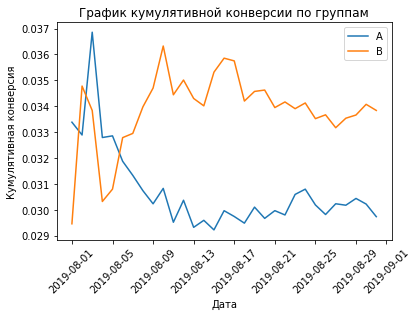

In [22]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.xticks(rotation=45)
plt.ylabel("Кумулятивная конверсия")
plt.xlabel("Дата")
plt.title('График кумулятивной конверсии по группам')
plt.legend()

В начале теста сегмент А имел гораздо большую конверсию, чем сегмент В, однако постепенно его конверсия начала падать, а сегмента В - расти. Постепенно конверсия В осталась стабильно больше сегмента А, как видно из графика.

Построим график относительного изменения кумулятивной конверсии группы B к группе A.

(array([737272., 737276., 737280., 737284., 737288., 737292., 737296.,
        737300., 737303.]),
 <a list of 9 Text xticklabel objects>)

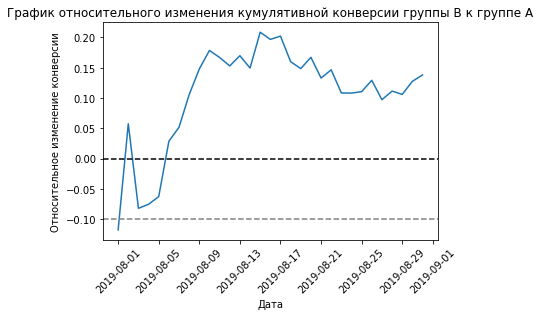

In [23]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A')
plt.ylabel("Относительное изменение конверсии")
plt.xlabel("Дата")
plt.xticks(rotation=45)

Группа В лидирует по конверсии почти с самого начала (с 5 августа), достигает пика между 13 и 17 августа (прирост почти в 20% относительно группы А) и постепенно падает до 15%. 

Построим точечный график количества заказов по пользователям.

In [24]:
orders_visitors = orders.groupby('visitor_id', as_index=False).agg({'transaction_id':'nunique'})
orders_visitors.columns = ['user_id', 'count_orders']
print(orders_visitors.sort_values(by='count_orders', ascending=False).head(10))

         user_id  count_orders
1023  4256040402            11
591   2458001652            11
569   2378935119             9
487   2038680547             8
44     199603092             5
744   3062433592             5
55     237748145             5
917   3803269165             5
299   1230306981             5
897   3717692402             5


Text(0.5, 0, 'Кол-во заказов, шт.')

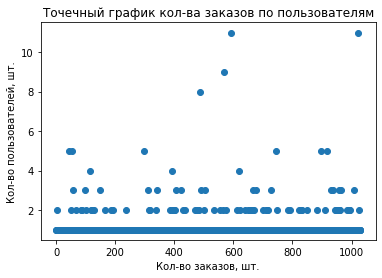

In [25]:
x_values = pd.Series(range(0,len(orders_visitors)))
plt.scatter(x_values, orders_visitors['count_orders']) 
plt.title('Точечный график кол-ва заказов по пользователям')
plt.ylabel("Кол-во пользователей, шт.")
plt.xlabel("Кол-во заказов, шт.")

Как видно из точечного графика, большинство пользователей совершает не более 1 заказа, некоторая часть совершает 2 заказа, больше двух заказов совершает совсем небольшое количество пользователей. Посчитаем выборочные перцентили: 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.

In [26]:
print('90 перцентиль: %.2f' % (np.percentile(orders_visitors['count_orders'], [90])))
print('95 перцентиль: %.2f' % (np.percentile(orders_visitors['count_orders'], [95])))
print('99 перцентиль: %.2f' % (np.percentile(orders_visitors['count_orders'], [99])))

90 перцентиль: 1.00
95 перцентиль: 2.00
99 перцентиль: 4.00


Не более 5% пользователей оформляли больше 2 заказов. И 10% пользователей заказывали более одного раза. Разумно выбрать 2 или 3 заказов на одного пользователя за нижнюю границу числа заказов, и отсеять аномальных пользователей по ней.

Построим точечный график стоимостей заказов. 

Text(0.5, 0, 'Кол-во пользователей, шт.')

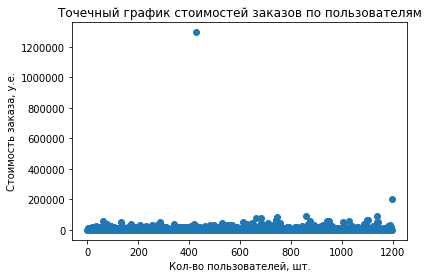

In [27]:
x_values_revenue = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values_revenue, orders['revenue'])
plt.title('Точечный график стоимостей заказов по пользователям')
plt.ylabel("Стоимость заказа, у.е.")
plt.xlabel("Кол-во пользователей, шт.")

На графике отчетливо видно два аномальных значения - кроме того, заказов на сумму более 200 тыс. нет вообще, а основная масса концентрируется в значениях менее 100 тыс. руб. Для более подробной информации необходимо посчитать 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.

In [28]:
print('90 перцентиль: %.2f' % (np.percentile(orders['revenue'], [90])))
print('95 перцентиль: %.2f' % (np.percentile(orders['revenue'], [95])))
print('99 перцентиль: %.2f' % (np.percentile(orders['revenue'], [99])))

90 перцентиль: 18168.00
95 перцентиль: 28000.00
99 перцентиль: 58233.20


Не более 5% пользователей оформляют заказы стоимостью более 28 тыс. у.е. и не более 1% дороже 58 тыс. у.е. В связи с чем границу аномальных заказов следует отметить заказы стоимостью более 60 тыс. у.е.

Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным. Сделаем выводы и предположения.

В первую очередь сформулируем нулевую и альтернативную гипотезы для проверки:

    H0: Конверсия в группе A равна конверсии в группе B
    H1: Конверсия в группе A не равна конверсии в группе B. 

Для проверки используем критерий Манна-Уитни.

In [29]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']
visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

print(data.head(5)) 

        date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0 2019-08-01              24           148579              21   
1 2019-08-02              20            93822              24   
2 2019-08-03              24           112473              16   
3 2019-08-04              16            70825              17   
4 2019-08-05              25           124218              23   

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0           101217                  24               148579   
1           165531                  44               242401   
2           114248                  68               354874   
3           108571                  84               425699   
4            92428                 109               549917   

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0                  21               101217               719   
1                  45               266748               619   
2                  61               38

In [30]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders']

In [31]:
pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')
[ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')]
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
print("{0:.5f}".format(st.mannwhitneyu(sampleA, sampleB)[1]))
print('{0:.3f}'.format((data['ordersPerDateB'].sum()/data['visitorsPerDateB'].sum())/(data['ordersPerDateA'].sum()/data['visitorsPerDateA'].sum())-1))

0.00840
0.138


Первое число — p-value = 0.008 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем. Соответственно, в конверсии между группами есть статистически значимые отличия. Однако относительный прирост конверсии группы B к конверсии группы А равен 13.8% — второе число в выводе.

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделаем выводы и предположения.

В первую очередь сформулируем нулевую и альтернативную гипотезы для проверки:

    H0: Средний чек группы A равен среднему чеку в группе B
    H1:Средний чек группы A отличается от среднего чека в группе B.
    
Для проверки используем критерий Манна-Уитни.

In [32]:
print('{0:.3f}'.format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.365
0.259


P-value значительно больше 0.05 (0.36). Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Кроме того, относительное различие среднего чека между сегментами составялет почти 26%.

Приступим к подготовке очищенных от аномалий данных. Напомним, что 95-й и 99-й перцентили средних чеков равны 28 000 и 58 223 рублям. А 95-й и 99-й перцентили числа заказов на одного пользователя равны 2 и 4 заказам на пользователя. Соответственно, примем за аномальных пользователей тех, кто совершил 4 заказа и более, или совершил заказ на сумму свыше 30 000 рублей. Так мы уберем 1% пользователей с наибольшим числом заказов и от 1% до 5% заказов с наибольшей стоимостью.

In [33]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 3]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] > 3]['visitor_id'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 30000]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print('Кол-во аномальных пользователей: {}'.format(len(abnormalUsers)))

Кол-во аномальных пользователей: 57


Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным. Сделаем выводы и предположения.

In [34]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('{0:.5f}'.format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.00916
0.148


Как мы видим из полученных данных, статистическая значимость достигнута (0.009 < 0.05). Кроме того, сегмент В лучше сегмента А на 14.8%. 

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделаем выводы и предположения.

In [35]:
print(
    '{0:.3f}'.format(
        st.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

0.479
-0.020


Как можно увидеть, статистическая значимость различия среднего чека заказов между группами не обнаружена. 

## Вывод

По результатам А/В теста были выявлены следующие факты:
Выборка данных имеет корректный размер, проблема подглядывания в результате сравнения групп во время проведения теста была исключена. 
1. В конверсии между группами есть статистически значимые отличия по конверсии между группами как по «сырым», так и по данным после фильтрации аномалий;
2. Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
3. График различия конверсии между группами сообщает, что результаты группы B лучше группы A, значительной тенденции к улучшению положения группы А нет;
4. График различия среднего чека говорит о том, что результаты группы B значительно лучше  (сейчас почти на 30%):
Лидером по кумулятивным метрикам по выручке, среднему чеку и конверсии практически везде была группа В. 

Варианты принимаемых решений: 
1. Остановить тест, зафиксировать победу одной из групп.
2. Остановить тест, зафиксировать отсутствие различий между группами.
3. Продолжить тест.

Наиболее верной стратегией кажется зафиксировать победу группы В, так как продолжать смысла нет, потому как вероятность, что при имеющихся данных сегмент А выйдет в лидеры, крайне небольшая.